# PRISM1 vs NMM3D Look-Up Table

This notebook mirrors the MATLAB comparison workflow for rough-surface backscatter.
It loads the NMM3D 40° NRCS look-up table, evaluates the SSRT PRISM1 model for the
same parameter combinations, and plots/quantifies how closely the model tracks the
reference values. Plots are grouped by correlation-length ratio (ℓ/σ) to simplify visual comparison.


In [1]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ssrt.surface.prism1 import PRISM1
from ssrt.utils.util import toLambda

NOTEBOOK_ROOT = Path.cwd().resolve()
DATA_DIR = NOTEBOOK_ROOT / 'data'
if not DATA_DIR.exists():
    DATA_DIR = NOTEBOOK_ROOT.parent / 'data'

MPL_CACHE = NOTEBOOK_ROOT / '.mpl-cache'
MPL_CACHE.mkdir(exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(MPL_CACHE))

LUT_PATH = DATA_DIR / 'NMM3D_LUT_NRCS_40degree.dat'
if not LUT_PATH.exists():
    raise FileNotFoundError(f'NMM3D LUT not found at {LUT_PATH}')

FREQUENCY_GHZ = 5.405
INCIDENCE_DEG = 40.0
TARGET_RATIOS = [4, 7, 10, 15]  # [] for all ratios, or provide specific values
MARKERS = {i: marker for i, marker in enumerate(['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x'])}
plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
def load_lut(path):
    data = np.loadtxt(path)
    return {
        'theta': data[:, 0],
        'ratio': data[:, 1],
        'eps_real': data[:, 2],
        'eps_imag': data[:, 3],
        'rms_norm': data[:, 4],
        'vv_db': data[:, 5],
        'hh_db': data[:, 6],
        'hv_db': data[:, 7],
    }


def filter_by_incidence(lut, angle_deg, tol=1e-3):
    mask = np.abs(lut['theta'] - angle_deg) <= tol
    if not np.any(mask):
        raise ValueError(f'No entries found at {angle_deg} degrees in LUT')
    return {key: val[mask] for key, val in lut.items()}


def compute_metrics(sim, ref):
    mask = np.isfinite(sim) & np.isfinite(ref)
    if not np.any(mask):
        return {'r': np.nan, 'rmse': np.nan, 'bias': np.nan, 'mae': np.nan, 'n': 0}
    sim = sim[mask]
    ref = ref[mask]
    diff = sim - ref
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    r = float(np.corrcoef(ref, sim)[0, 1]) if sim.size > 1 else np.nan
    return {'r': r, 'rmse': rmse, 'bias': bias, 'mae': mae, 'n': int(sim.size)}


In [3]:
lut = load_lut(LUT_PATH)
subset = filter_by_incidence(lut, INCIDENCE_DEG)

ratios_all = np.unique(subset['ratio'])
if TARGET_RATIOS:
    target = np.array(TARGET_RATIOS, dtype=float)
    mask = np.isin(subset['ratio'], target)
    subset = {k: v[mask] for k, v in subset.items()}
    ratios_used = np.unique(subset['ratio'])
else:
    ratios_used = ratios_all

if subset['ratio'].size == 0:
    raise ValueError('No LUT entries left after ratio filtering.')

print(f'Ratios in use: {np.array2string(ratios_used, precision=2)}')

group_results = []
reference_rows = defaultdict(list)

lambda_m = toLambda(FREQUENCY_GHZ)

unique_groups = np.unique(
    np.vstack([
        subset['ratio'],
        subset['eps_real'],
        subset['eps_imag']
    ]).T,
    axis=0
)

for ratio, eps_r, eps_i in unique_groups:
    mask = (
        np.isclose(subset['ratio'], ratio)
        & np.isclose(subset['eps_real'], eps_r)
        & np.isclose(subset['eps_imag'], eps_i)
    )
    if not np.any(mask):
        continue
    idx = np.argsort(subset['rms_norm'][mask])
    rms_norm = subset['rms_norm'][mask][idx]
    vv_ref = subset['vv_db'][mask][idx]
    hh_ref = subset['hh_db'][mask][idx]
    hv_ref = subset['hv_db'][mask][idx]

    sigma = rms_norm * lambda_m

    model = PRISM1(
        f=FREQUENCY_GHZ,
        theta_i=INCIDENCE_DEG,
        eps=complex(eps_r, eps_i),
        s=sigma
    )
    vv_model, hh_model, hv_model, _ = model.calc_sigma()

    group_results.append({
        'ratio': ratio,
        'eps_real': eps_r,
        'eps_imag': eps_i,
        'ks': 2 * np.pi * rms_norm,
        'vv_ref': vv_ref,
        'hh_ref': hh_ref,
        'hv_ref': hv_ref,
        'vv_model': vv_model,
        'hh_model': hh_model,
        'hv_model': hv_model,
    })

    reference_rows['vv_ref'].append(vv_ref)
    reference_rows['hh_ref'].append(hh_ref)
    reference_rows['hv_ref'].append(hv_ref)
    reference_rows['vv_model'].append(vv_model)
    reference_rows['hh_model'].append(hh_model)
    reference_rows['hv_model'].append(hv_model)

print(f'Groups compared: {len(group_results)}')


Ratios in use: [ 4.  7. 10. 15.]
Groups compared: 24


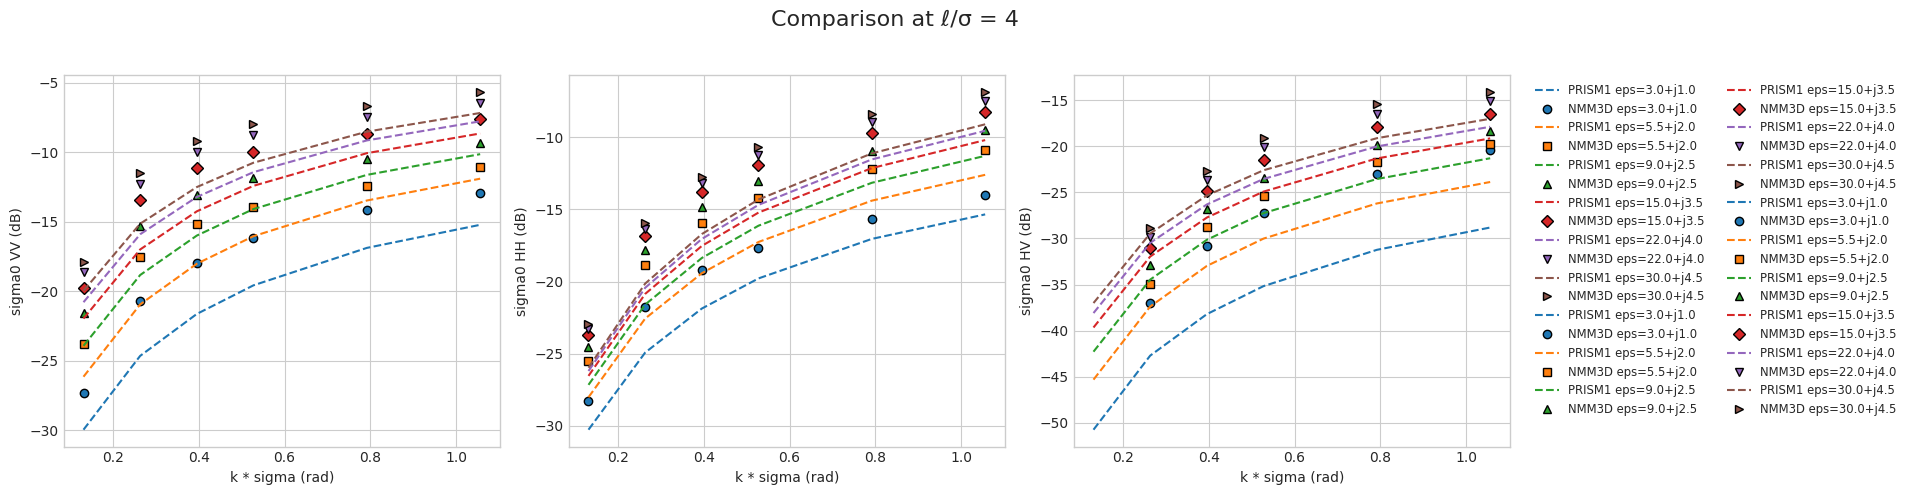

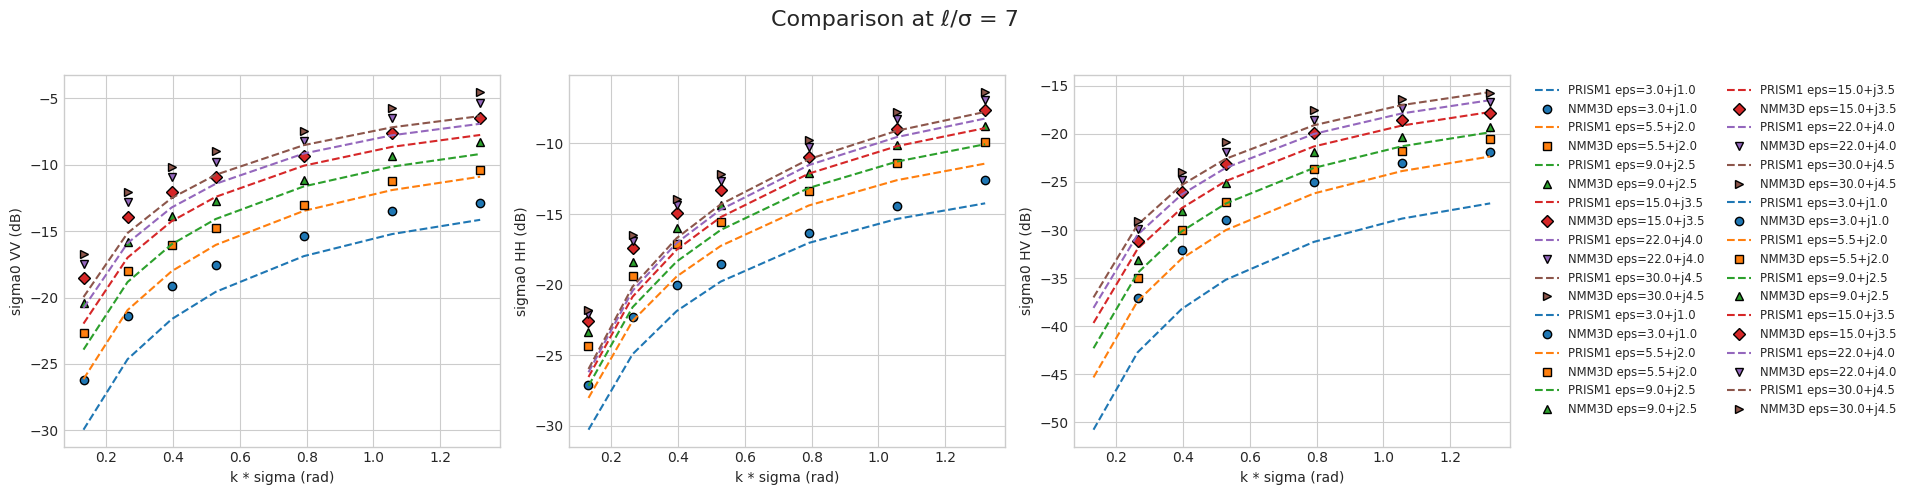

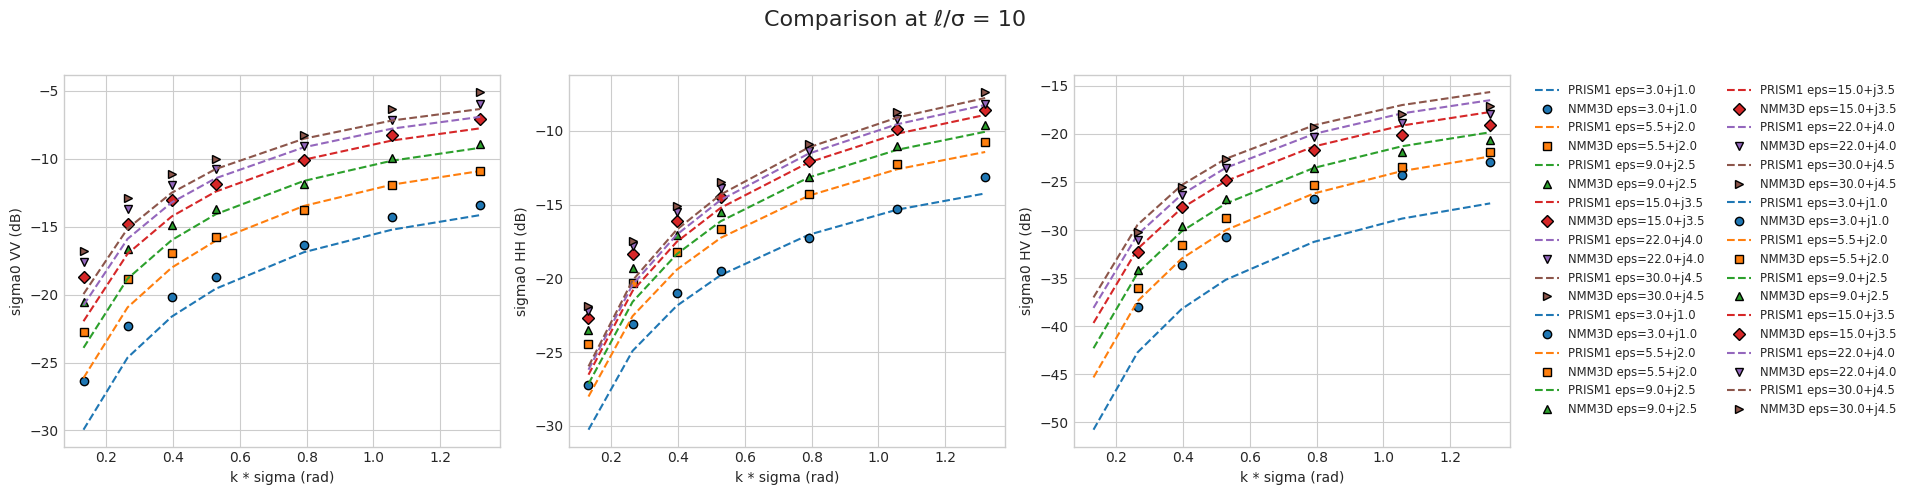

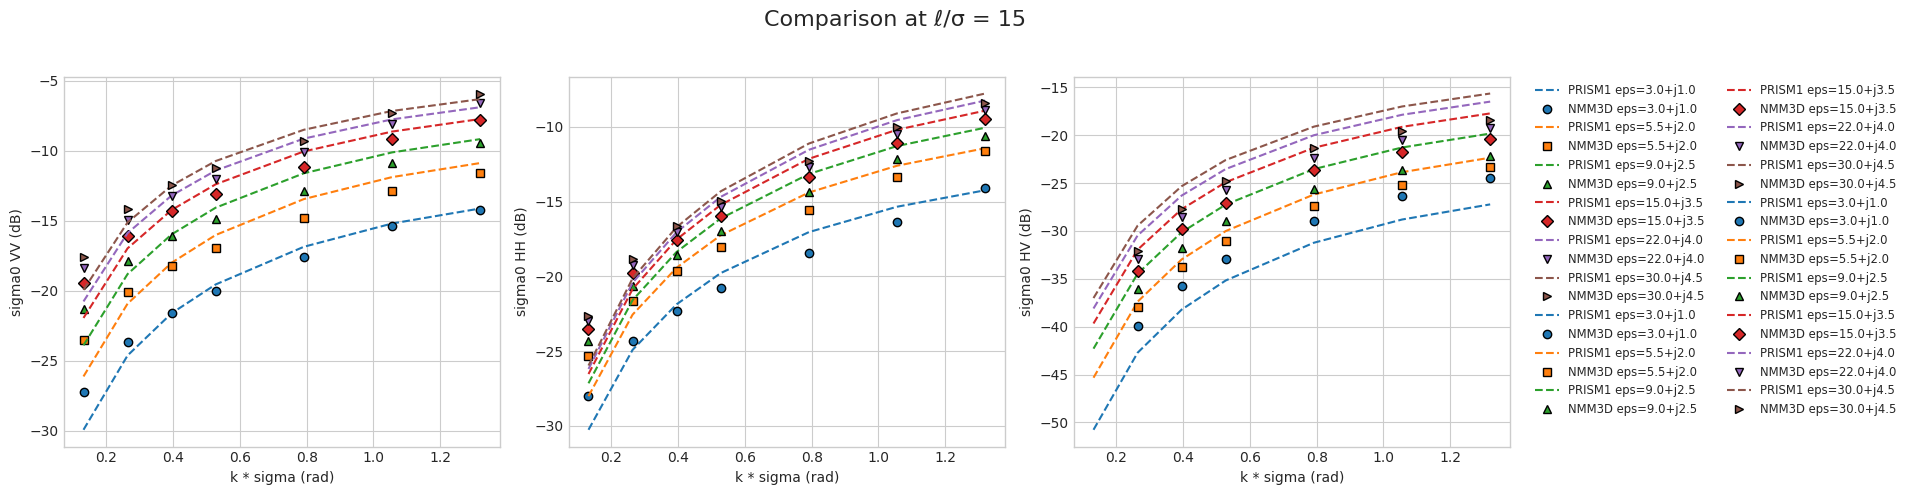

In [4]:
if not group_results:
    raise RuntimeError('No group comparisons available for plotting.')

unique_dielectrics = sorted({(g['eps_real'], g['eps_imag']) for g in group_results})
color_map = {die: plt.cm.tab10(i % 10) for i, die in enumerate(unique_dielectrics)}

ratio_groups = {}
for group in group_results:
    ratio_groups.setdefault(group['ratio'], []).append(group)

for ratio in sorted(ratio_groups):
    groups = ratio_groups[ratio]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    bands = [('vv', 'sigma0 VV (dB)'), ('hh', 'sigma0 HH (dB)'), ('hv', 'sigma0 HV (dB)')]

    handles = []
    labels = []

    for ax, (band_key, ylabel) in zip(axes, bands):
        plotted_labels = set()
        for group in groups:
            eps_pair = (group['eps_real'], group['eps_imag'])
            color = color_map[eps_pair]
            marker = MARKERS[unique_dielectrics.index(eps_pair) % len(MARKERS)]
            ks = group['ks']
            model_vals = group[f'{band_key}_model']
            ref_vals = group[f'{band_key}_ref']

            label_model = f'PRISM1 eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}'
            if label_model not in plotted_labels:
                line, = ax.plot(ks, model_vals, linestyle='--', color=color, label=label_model)
                handles.append(line)
                labels.append(label_model)
                plotted_labels.add(label_model)
            else:
                ax.plot(ks, model_vals, linestyle='--', color=color)

            finite_mask = np.isfinite(ref_vals)
            if np.any(finite_mask):
                label_ref = f'NMM3D eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}'
                if label_ref not in plotted_labels:
                    pts = ax.plot(
                        ks[finite_mask],
                        ref_vals[finite_mask],
                        linestyle='none',
                        marker=marker,
                        markersize=6,
                        markerfacecolor=color,
                        markeredgecolor='black',
                        label=label_ref
                    )[0]
                    handles.append(pts)
                    labels.append(label_ref)
                    plotted_labels.add(label_ref)
                else:
                    ax.plot(
                        ks[finite_mask],
                        ref_vals[finite_mask],
                        linestyle='none',
                        marker=marker,
                        markersize=6,
                        markerfacecolor=color,
                        markeredgecolor='black'
                    )

        ax.set_xlabel('k * sigma (rad)')
        ax.set_ylabel(ylabel)
        ax.grid(True)

    fig.suptitle(f'Comparison at ℓ/σ = {ratio:g}', fontsize=16)
    if handles:
        fig.legend(handles, labels, bbox_to_anchor=(0.85, 0.5), loc='center left', fontsize='small', ncol=2)
    fig.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


In [5]:
metrics_tables = []
for ratio in sorted(ratio_groups):
    groups = ratio_groups[ratio]
    rows = []
    for band, label in [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]:
        ref_segments = [g[f'{band}_ref'] for g in groups]
        sim_segments = [g[f'{band}_model'] for g in groups]
        if not ref_segments:
            rows.append({'ratio': ratio, 'Band': label, 'Samples': 0, 'RMSE (dB)': np.nan, 'Bias (dB)': np.nan, 'MAE (dB)': np.nan, 'Correlation r': np.nan})
            continue
        ref = np.concatenate(ref_segments)
        sim = np.concatenate(sim_segments)
        stats = compute_metrics(sim, ref)
        rows.append({
            'ratio': ratio,
            'Band': label,
            'Samples': stats['n'],
            'RMSE (dB)': stats['rmse'],
            'Bias (dB)': stats['bias'],
            'MAE (dB)': stats['mae'],
            'Correlation r': stats['r'],
        })
    metrics_tables.append(pd.DataFrame(rows))

if metrics_tables:
    metrics_df = pd.concat(metrics_tables, ignore_index=True).set_index(['ratio', 'Band'])
else:
    metrics_df = pd.DataFrame(columns=['ratio', 'Band', 'Samples', 'RMSE (dB)', 'Bias (dB)', 'MAE (dB)', 'Correlation r']).set_index(['ratio', 'Band'])
metrics_df


Samples  RMSE (dB)  Bias (dB)  MAE (dB)  Correlation r
ratio Band                                                        
4.0   VV         36   2.595371  -2.437995  2.437995       0.988629
      HH         36   2.981176  -2.874156  2.874156       0.990309
      HV         30   4.254098  -3.759589  3.759589       0.949284
7.0   VV         42   2.174260  -1.942770  1.942770       0.992616
      HH         42   2.378077  -2.145345  2.145345       0.993560
      HV         36   2.816362  -2.114018  2.133240       0.968570
10.0  VV         42   1.647465  -1.228485  1.257193       0.989875
      HH         42   1.780084  -1.272012  1.281937       0.991460
      HV         36   1.973287  -0.640407  1.263540       0.970561
15.0  VV         42   1.150358  -0.155151  0.860930       0.986884
      HH         42   1.349136  -0.062964  1.058562       0.988017
      HV         36   2.199124   1.286538  2.117881       0.971092

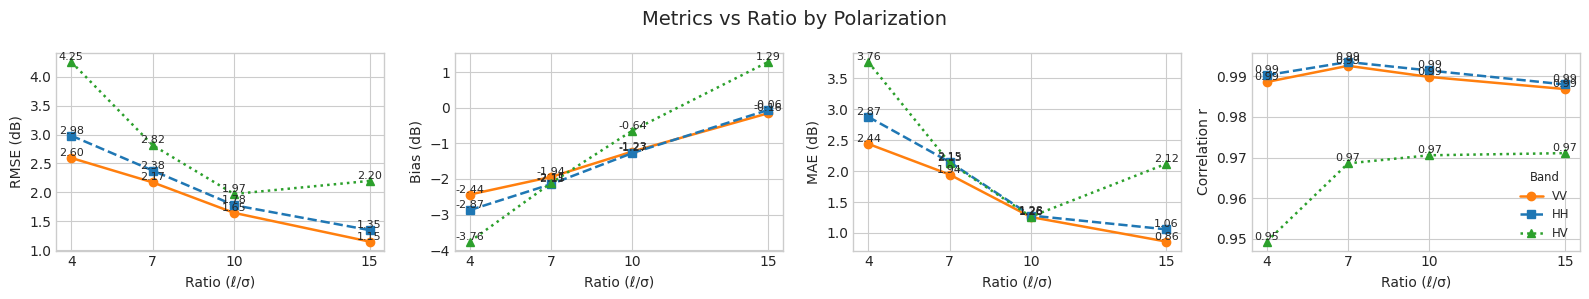

In [6]:
# stacked 4x1 plots: one row per metric, lines for VV/HH/HV across ratios
bands = ['VV', 'HH', 'HV']
metrics = ['RMSE (dB)', 'Bias (dB)', 'MAE (dB)', 'Correlation r']
ratios_plot = np.array(sorted(metrics_df.index.get_level_values(0).unique()))

# simple consistent styles per band
band_styles = {
    'VV': dict(color=plt.cm.tab10(1), linestyle='-', marker='o'),
    'HH': dict(color=plt.cm.tab10(0), linestyle='--', marker='s'),
    'HV': dict(color=plt.cm.tab10(2), linestyle=':', marker='^'),
}

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 3))
fig.suptitle('Metrics vs Ratio by Polarization', fontsize=14)

for i, metric in enumerate(metrics):
    ax = axes[i]
    for band in bands:
        vals = []
        for r in ratios_plot:
            try:
                vals.append(float(metrics_df.loc[(r, band), metric]))
            except Exception:
                vals.append(np.nan)
        vals = np.array(vals, dtype=float)
        style = band_styles[band]
        ax.plot(ratios_plot, vals, label=band,
                color=style['color'], linestyle=style['linestyle'],
                marker=style['marker'], linewidth=1.8, markersize=6)
        # annotate points
        for x, y in zip(ratios_plot, vals):
            if np.isfinite(y):
                ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Ratio (ℓ/σ)')
    ax.set_xticks(ratios_plot)

    if i == 3:
        ax.legend(title='Band', fontsize='small', title_fontsize='small')
        
fig.tight_layout()
plt.show()


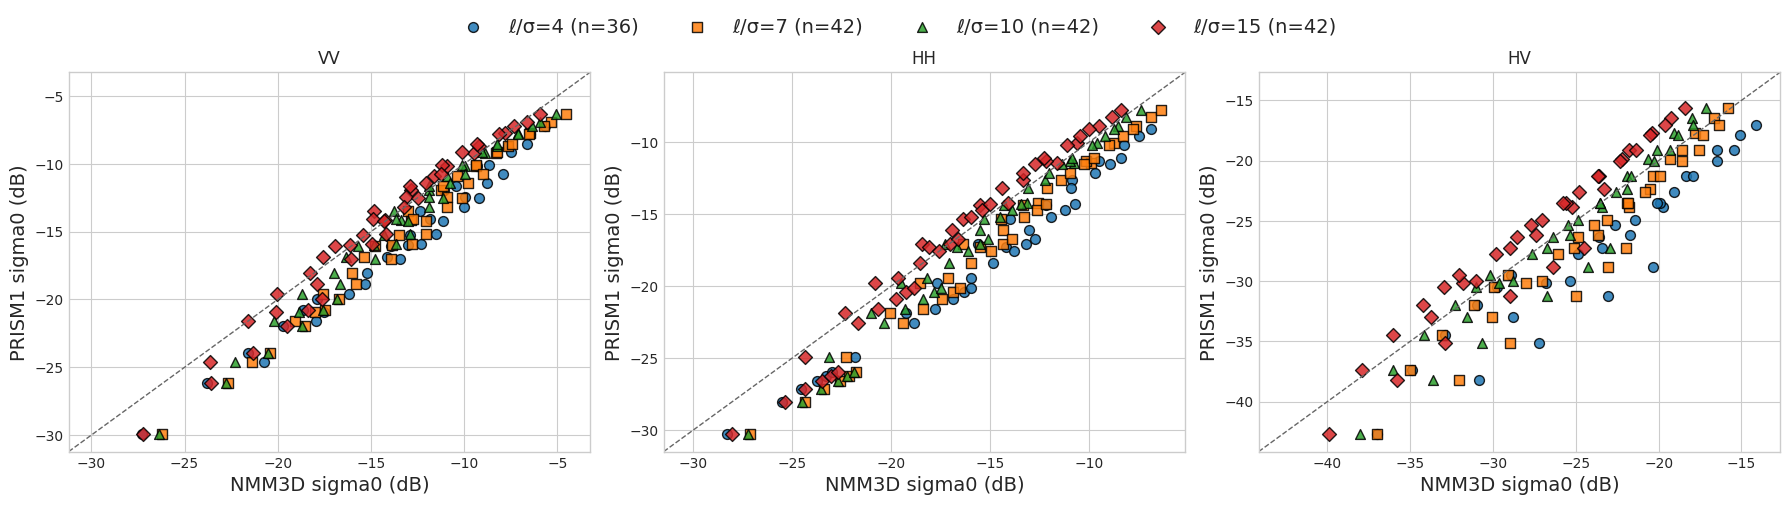

In [7]:
# scatter predicted vs measured per band, with ratios in different colors/styles
ratios = sorted(ratio_groups.keys())
markers = list(MARKERS.values())
colors = [plt.cm.tab10(i % 10) for i in range(len(ratios))]

bands = [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

# store axis extents to draw 1:1 line consistently per subplot
extents = {bkey: [np.inf, -np.inf] for bkey, _ in bands}

for i, ratio in enumerate(ratios):
    groups = ratio_groups[ratio]
    marker = markers[i % len(markers)]
    color = colors[i]
    for ax_idx, (bkey, bname) in enumerate(bands):
        ref_segs = [g[f'{bkey}_ref'] for g in groups]
        sim_segs = [g[f'{bkey}_model'] for g in groups]
        if not ref_segs or not sim_segs:
            continue
        ref = np.concatenate(ref_segs)
        sim = np.concatenate(sim_segs)
        mask = np.isfinite(ref) & np.isfinite(sim)
        if not np.any(mask):
            # for HV there may be -inf measured entries; skip those points
            mask = np.isfinite(ref) & np.isfinite(sim)
        if not np.any(mask):
            continue
        ax = axes[ax_idx]
        ax.scatter(ref[mask], sim[mask],
                   label=f'ℓ/σ={ratio:g} (n={mask.sum()})',
                   color=color, marker=marker, edgecolor='black', alpha=0.85, s=50)
        # update extents
        combined_min = min(np.nanmin(ref[mask]), np.nanmin(sim[mask]))
        combined_max = max(np.nanmax(ref[mask]), np.nanmax(sim[mask]))
        extents[bkey][0] = min(extents[bkey][0], combined_min)
        extents[bkey][1] = max(extents[bkey][1], combined_max)

# finalize each subplot: 1:1 line, labels, titles
for ax_idx, (bkey, bname) in enumerate(bands):
    ax = axes[ax_idx]
    lo, hi = extents[bkey]
    if not np.isfinite(lo) or not np.isfinite(hi):
        # fallback to autoscale if nothing plotted
        ax.autoscale()
    else:
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        ax.set_xlim(lo - pad, hi + pad)
        ax.set_ylim(lo - pad, hi + pad)
        ax.plot([lo - pad, hi + pad], [lo - pad, hi + pad], color='0.4', linestyle='--', linewidth=1)
    ax.set_xlabel('NMM3D sigma0 (dB)', fontsize=14)
    ax.set_ylabel('PRISM1 sigma0 (dB)', fontsize=14)
    ax.set_title(f'{bname}')
    ax.grid(True)

# shared legend (ratios)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(len(ratios), 6), bbox_to_anchor=(0.5, 1.02), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
